# 1. Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

from pyod.models.iforest import IForest
from pyod.models.pca import PCA

from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

import tensorflow as tf

import seaborn as sns
sns.set_style('white')

import warnings
warnings.filterwarnings(action='ignore')

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9735067592889188689
xla_global_id: -1
]
[]


In [3]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0' # 여러개 사용시 '0,1,2' 식으로 하나의 문자열에 입력
gpus = tf.config.experimental.list_physical_devices('GPU') # 호스트 러나임에 표시되는 GPU 장치 목록 반환

if gpus: # 반환된 GPU 장치 목록이 있다면
    try: # 해당 장치에 대한 메모리 증가 활성화 여부 설정
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e: # try문 실패시에 에러문구 출력
        print(e)

In [4]:
path = "./Dataset/"

dataT = pd.read_csv(path+"train_T.csv")  
dataO = pd.read_csv(path+"train_O.csv")  

# original data -> data
data = pd.concat([dataT, dataO]).reset_index(drop=True)
data

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,0.531957,T100304,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,0.531105,T100306,T_31,2.0,96.0,0.0,45.0,10.0,0.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,0.532292,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.528141,T100306,T_31,2.0,87.0,0.0,45.0,10.0,0.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,0.532289,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,1,0.529740,T100304,O_31,154.0,97.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
834,1,0.532343,T100306,O_31,146.0,94.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
835,1,0.530533,T100304,O_31,4.0,98.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
836,2,0.535205,T100306,O_31,6.0,89.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Preprocessing

1. 같은 값으로만 채워진 column 삭제 (nunique(dropna=False) <= 1) 
2. 모든 행이 같은 값을 가지는 두 개 이상의 중복된 column 삭제 
3. 결측치 처리 (KNN Imputetor, fillna(0))
4. 정규화 (Robust, MinMax, Standard)
5. 카테고리 변수 수치화 (LINE, PRODUCT_CODE) LabelEncoder

In [225]:
# 1. Handling missing values  
# Preprocessed data -> processed_data
processed_data = data.drop(['Y_Class'], axis=1).copy()
processed_data = processed_data.fillna(0)
processed_data

,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,0.531957,T100304,T_31,2.0,95.0,0.0,45.0,10.0,0.0,45.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,0.531105,T100306,T_31,2.0,96.0,0.0,45.0,10.0,0.0,53.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,0.532292,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,60.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
3,0.528141,T100306,T_31,2.0,87.0,0.0,45.0,10.0,0.0,53.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,0.532289,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,51.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,0.529740,T100304,O_31,154.0,97.0,0.0,45.0,11.0,0.0,45.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
834,0.532343,T100306,O_31,146.0,94.0,0.0,45.0,10.0,0.0,67.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
835,0.530533,T100304,O_31,4.0,98.0,0.0,45.0,11.0,0.0,45.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
836,0.535205,T100306,O_31,6.0,89.0,0.0,45.0,10.0,0.0,51.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000


In [226]:
# 2. 같은 값으로만 채워진 column 삭제 (nunique(dropna=False) <= 1)
# Get the counts of unique values per column
value_counts = processed_data.iloc[:,4:].apply(lambda x: x.nunique(dropna=False))

# Filter columns with only one unique value
unique_columns = value_counts[value_counts >= 2].index
duplicated_columns = value_counts[value_counts <= 1].index

processed_data = processed_data.drop(duplicated_columns, axis=1)
processed_data

,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,X_9,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,0.531957,T100304,T_31,2.0,95.0,45.0,10.0,45.0,10.0,31.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,0.531105,T100306,T_31,2.0,96.0,45.0,10.0,53.0,10.0,52.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,0.532292,T100306,T_31,2.0,95.0,45.0,10.0,60.0,10.0,52.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
3,0.528141,T100306,T_31,2.0,87.0,45.0,10.0,53.0,10.0,52.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,0.532289,T100306,T_31,2.0,95.0,45.0,10.0,51.0,10.0,52.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,0.529740,T100304,O_31,154.0,97.0,45.0,11.0,45.0,10.0,31.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
834,0.532343,T100306,O_31,146.0,94.0,45.0,10.0,67.0,11.0,52.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
835,0.530533,T100304,O_31,4.0,98.0,45.0,11.0,45.0,10.0,31.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
836,0.535205,T100306,O_31,6.0,89.0,45.0,10.0,51.0,10.0,52.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000


In [227]:
# 3. 모든 행이 같은 값을 가지는 두 개 이상의 중복된 column 삭제
df = processed_data.iloc[:,4:].T.drop_duplicates(keep='first').T
processed_data = pd.concat([processed_data.iloc[:,:4], df], axis=1)
processed_data

,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,X_9,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,0.531957,T100304,T_31,2.0,95.0,45.0,10.0,45.0,10.0,31.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,0.531105,T100306,T_31,2.0,96.0,45.0,10.0,53.0,10.0,52.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,0.532292,T100306,T_31,2.0,95.0,45.0,10.0,60.0,10.0,52.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
3,0.528141,T100306,T_31,2.0,87.0,45.0,10.0,53.0,10.0,52.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,0.532289,T100306,T_31,2.0,95.0,45.0,10.0,51.0,10.0,52.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,0.529740,T100304,O_31,154.0,97.0,45.0,11.0,45.0,10.0,31.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
834,0.532343,T100306,O_31,146.0,94.0,45.0,10.0,67.0,11.0,52.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
835,0.530533,T100304,O_31,4.0,98.0,45.0,11.0,45.0,10.0,31.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
836,0.535205,T100306,O_31,6.0,89.0,45.0,10.0,51.0,10.0,52.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000


In [228]:
# 4. Regularization 
rs = RobustScaler()
ss = StandardScaler()

processed_data.iloc[:, 4:] = rs.fit_transform(processed_data.iloc[:, 4:])
processed_data

,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,X_9,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,0.531957,T100304,T_31,2.0,0.0,0.0,0.0,-0.833333,0.0,-1.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,0.531105,T100306,T_31,2.0,0.2,0.0,0.0,0.500000,0.0,0.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,0.532292,T100306,T_31,2.0,0.0,0.0,0.0,1.666667,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
3,0.528141,T100306,T_31,2.0,-1.6,0.0,0.0,0.500000,0.0,0.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,0.532289,T100306,T_31,2.0,0.0,0.0,0.0,0.166667,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,0.529740,T100304,O_31,154.0,0.4,0.0,1.0,-0.833333,0.0,-1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
834,0.532343,T100306,O_31,146.0,-0.2,0.0,0.0,2.833333,1.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
835,0.530533,T100304,O_31,4.0,0.6,0.0,1.0,-0.833333,0.0,-1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
836,0.535205,T100306,O_31,6.0,-1.2,0.0,0.0,0.166667,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000


In [229]:
# 5. Label Encoding 
cat_cols = ['PRODUCT_CODE', 'LINE']

for col in cat_cols:
    le = LabelEncoder()
    processed_data[col] = le.fit_transform(processed_data[col])
    print(le.classes_)

processed_data.head()

['O_31' 'T_31']
['T100304' 'T100306']


,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,X_9,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,0.531957,0,1,2.0,0.0,0.0,0.0,-0.833333,0.0,-1.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,0.531105,1,1,2.0,0.2,0.0,0.0,0.500000,0.0,0.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,0.532292,1,1,2.0,0.0,0.0,0.0,1.666667,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
3,0.528141,1,1,2.0,-1.6,0.0,0.0,0.500000,0.0,0.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,0.532289,1,1,2.0,0.0,0.0,0.0,0.166667,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000


In [230]:
# 5. 차원 축소
from sklearn.decomposition import PCA 

nonX_data = processed_data.iloc[:, :3]
X_data = processed_data.iloc[:, 3:]

pca = PCA(n_components=3)
pca_data = pca.fit_transform(X_data) 
pca_df = pd.DataFrame(pca_data) # , columns=['X1', 'X2', 'X3']

processed_data = pd.concat([nonX_data, pca_df], axis=1)
processed_data

,Y_Quality,LINE,PRODUCT_CODE,0,1,2
0,0.531957,0,1,16101.086813,-974.254424,-113.890426
1,0.531105,1,1,46349.903278,-1702.853292,172.964842
2,0.532292,1,1,-5094.754043,90.722540,-133.792450
3,0.528141,1,1,-3136.625768,-382.507494,-293.712963
4,0.532289,1,1,-5094.754110,90.722835,-133.793045
...,...,...,...,...,...,...
833,0.529740,0,0,-5094.760959,90.719835,-133.999758
834,0.532343,1,0,-5094.762151,90.722869,-134.045113
835,0.530533,0,0,-5094.753880,90.723373,-133.792056
836,0.535205,1,0,-5094.754097,90.722048,-133.788710


# 3. Data Split

In [231]:
# Divide processed_data to input_data_X and input_data_y 
input_data = processed_data.copy()
input_data_y = processed_data['Y_Quality']
input_data_X = processed_data.drop(['Y_Quality'], axis=1)

# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = SEED,
    shuffle=True
)

# valid/train 로 split
train_X, valid_X, train_y, valid_y = train_test_split(
    tr_val_X, 
    tr_val_y, 
    test_size = 0.2, 
    random_state = SEED,
    shuffle=True
)

print('Input Data X:', input_data_X.shape, 'Input Data y:', input_data_y.shape)
print('X_train:', train_X.shape, 'y_train:', train_y.shape)
print('X_valid:', valid_X.shape, 'y_train:', valid_y.shape)
print('X_test:', test_X.shape, 'y_train:', test_y.shape)

Input Data X: (838, 5) Input Data y: (838,)
X_train: (536, 5) y_train: (536,)
X_valid: (134, 5) y_train: (134,)
X_test: (168, 5) y_train: (168,)


In [232]:
train_X

,LINE,PRODUCT_CODE,0,1,2
651,1,1,31631.741911,-1306.950731,34.537715
607,0,1,-5094.758345,90.738738,-133.932358
427,1,1,-5094.758281,90.736258,-133.942270
165,1,1,-5094.744696,90.693156,-133.980315
316,0,1,-5094.758515,90.739436,-133.928319
...,...,...,...,...,...
327,1,1,-5094.745095,90.693775,-133.981374
424,0,1,-5094.744638,90.699351,-133.983773
606,0,1,20167.121860,-1077.420124,-76.139794
626,0,1,35749.213248,-1472.416339,68.335028


# 4. Modeling 

1. Isolation Forest 
2. LOF (Local Outlier Factor)
3. PCA 
4. AutoEncoder 

In [233]:
from pycaret.regression import *
from time import time

In [234]:
# Setup Environment  
cat_cols = ['LINE', 'PRODUCT_CODE']
FOLD = 5

reg = setup(data = input_data, 
            train_size = 0.8,
            # test_data = test,
            target = 'Y_Quality',
            ignore_features = cat_cols,
            preprocess = False,  # default True
#            categorical_features = cat_cols,
#            fold_strategy = 'stratifiedkfold', # default 
            #numeric_features = num_cols,
            #ordinal_features = ord_dict,
            #high_cardinality_features = ['religion'],
            #high_cardinality_method = 'frequency',
            #handle_unknown_categorical = True,
            #normalize = True,
            #normalize_method = 'zscore', 
            #feature_selection = True, 
            #imputation_type='iterative',
            fold=FOLD, # defualt 10 
            fold_shuffle=True,
            use_gpu = True,
            session_id = SEED)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Description,Value
0,Session id,42
1,Target,Y_Quality
2,Target type,Regression
3,Original data shape,"(838, 6)"
4,Transformed data shape,"(838, 4)"
5,Transformed train set shape,"(670, 4)"
6,Transformed test set shape,"(168, 4)"
7,Ignore features,2
8,Numeric features,3


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

In [235]:
# EG, Cat, GBR, LGBM, XGB
top5 = compare_models(sort='r2', n_select=5, fold=FOLD, exclude=['lar', 'par', 'huber'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0036,0.0000,0.0053,0.1355,0.0034,0.0068,27.3000
lightgbm,Light Gradient Boosting Machine,0.0037,0.0000,0.0053,0.1116,0.0035,0.0071,5.6400
knn,K Neighbors Regressor,0.0038,0.0000,0.0054,0.1075,0.0035,0.0072,1.0120
gbr,Gradient Boosting Regressor,0.0037,0.0000,0.0055,0.0619,0.0036,0.0069,8.8920
ada,AdaBoost Regressor,0.0039,0.0000,0.0055,0.0368,0.0036,0.0074,3.6820
rf,Random Forest Regressor,0.0039,0.0000,0.0056,0.0267,0.0036,0.0073,5.8360
ridge,Ridge Regression,0.0038,0.0000,0.0056,0.0139,0.0037,0.0071,0.0460
br,Bayesian Ridge,0.0038,0.0000,0.0056,0.0139,0.0037,0.0071,0.0800
lr,Linear Regression,0.0038,0.0000,0.0056,0.0139,0.0037,0.0071,0.0420
en,Elastic Net,0.0038,0.0000,0.0057,0.0041,0.0037,0.0071,0.0440


In [236]:
total_models = []
tuned_models = []

for i, model in enumerate(top5):
    cell_start_time = time() 
    print(top5[i])
    model = create_model(model, fold=FOLD)
    #tuned_model = tune_model(model, fold=5, optimize='r2', choose_better=True)
    total_models.append(model)
    #tuned_models.append(tuned_model)
    cell_end_time = time()
    print("CELL RUN TIME: ", cell_end_time - cell_start_time)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0040,0.0000,0.0059,0.1321,0.0038,0.0075
1,0.0031,0.0000,0.0043,0.2976,0.0028,0.0058
2,0.0038,0.0000,0.0055,0.1174,0.0036,0.0072
3,0.0038,0.0000,0.0055,0.1656,0.0036,0.0072
4,0.0035,0.0000,0.0051,-0.0352,0.0033,0.0065
Mean,0.0036,0.0000,0.0053,0.1355,0.0034,0.0068
Std,0.0003,0.0000,0.0005,0.1065,0.0003,0.0006


CELL RUN TIME:  180.97890520095825
LGBMRegressor(device='gpu', n_jobs=-1, random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0041,0.0000,0.0061,0.0676,0.0040,0.0077
1,0.0032,0.0000,0.0043,0.2924,0.0028,0.0061
2,0.0038,0.0000,0.0056,0.0900,0.0037,0.0072
3,0.0040,0.0000,0.0055,0.1738,0.0036,0.0075
4,0.0036,0.0000,0.0052,-0.0665,0.0034,0.0068
Mean,0.0037,0.0000,0.0053,0.1115,0.0035,0.0070
Std,0.0003,0.0000,0.0006,0.1189,0.0004,0.0006


CELL RUN TIME:  11.984507322311401
KNeighborsRegressor(n_jobs=-1)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0039,0.0000,0.0059,0.1247,0.0038,0.0074
1,0.0035,0.0000,0.0047,0.1498,0.0031,0.0067
2,0.0040,0.0000,0.0055,0.1157,0.0036,0.0076
3,0.0040,0.0000,0.0056,0.1525,0.0036,0.0074
4,0.0036,0.0000,0.0051,-0.0055,0.0033,0.0067
Mean,0.0038,0.0000,0.0054,0.1075,0.0035,0.0072
Std,0.0002,0.0000,0.0004,0.0582,0.0003,0.0004


CELL RUN TIME:  7.108806610107422
GradientBoostingRegressor(random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0039,0.0000,0.0062,0.0199,0.0041,0.0074
1,0.0032,0.0000,0.0047,0.1836,0.0030,0.0060
2,0.0039,0.0000,0.0059,0.0045,0.0038,0.0073
3,0.0040,0.0000,0.0057,0.1164,0.0037,0.0075
4,0.0034,0.0000,0.0051,-0.0149,0.0033,0.0064
Mean,0.0037,0.0000,0.0055,0.0619,0.0036,0.0069
Std,0.0003,0.0000,0.0006,0.0758,0.0004,0.0006


CELL RUN TIME:  86.17076396942139
AdaBoostRegressor(random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0042,0.0000,0.0062,0.0179,0.0041,0.0080
1,0.0031,0.0000,0.0045,0.2526,0.0029,0.0058
2,0.0042,0.0000,0.0057,0.0514,0.0037,0.0079
3,0.0043,0.0000,0.0056,0.1301,0.0037,0.0081
4,0.0039,0.0000,0.0057,-0.2682,0.0037,0.0073
Mean,0.0039,0.0000,0.0055,0.0368,0.0036,0.0074
Std,0.0005,0.0000,0.0006,0.1725,0.0004,0.0009


CELL RUN TIME:  17.59351372718811


In [237]:
blender_top5 = blend_models(estimator_list=total_models)
#blender_tuned5 = blend_models(estimator_list=tuned_models)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0039,0.0000,0.0059,0.1202,0.0039,0.0073
1,0.0031,0.0000,0.0043,0.3067,0.0028,0.0058
2,0.0038,0.0000,0.0054,0.1479,0.0035,0.0071
3,0.0038,0.0000,0.0054,0.2184,0.0035,0.0071
4,0.0034,0.0000,0.0051,-0.0111,0.0033,0.0064
Mean,0.0036,0.0000,0.0052,0.1564,0.0034,0.0068
Std,0.0003,0.0000,0.0005,0.1057,0.0003,0.0006


In [238]:
# for naive models 
total_predictions = []
for model in total_models: 
    pred = predict_model(model)
    total_predictions.append(pred)
print() 

# for tuned models 
# for model in tuned_models: 
#     prediction = predict_model(model)
# print() 

# for blended model 
pred_blend_top5 = predict_model(blender_top5)
print() 

# for blended model (tuned)
#pred_blend_tuned5 = predict_model(blender_tuned5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.0035,0.0000,0.0049,0.1038,0.0032,0.0065


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0038,0.0000,0.0049,0.0922,0.0032,0.0071


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.0036,0.0000,0.0050,0.0837,0.0032,0.0067


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.0035,0.0000,0.0049,0.1256,0.0032,0.0066


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.0035,0.0000,0.0050,0.0806,0.0032,0.0066


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0034,0.0000,0.0047,0.1613,0.0031,0.0064


In [220]:
CHECK = 2

In [221]:
evaluate_model(total_models[CHECK])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

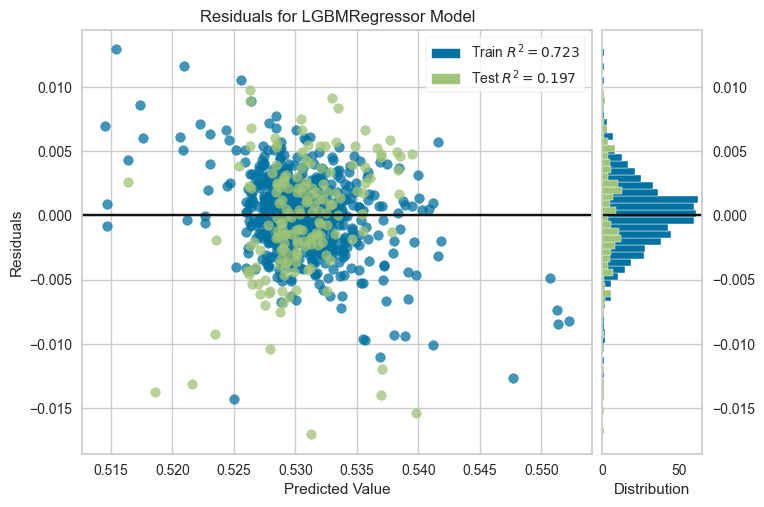

In [222]:
plot_model(total_models[CHECK], plot='residuals')

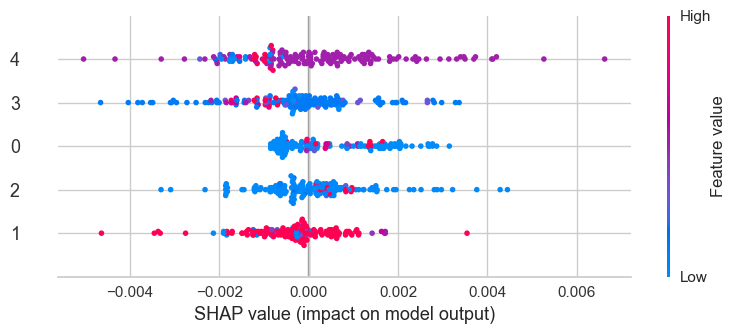

In [223]:
interpret_model(total_models[CHECK], plot='summary')

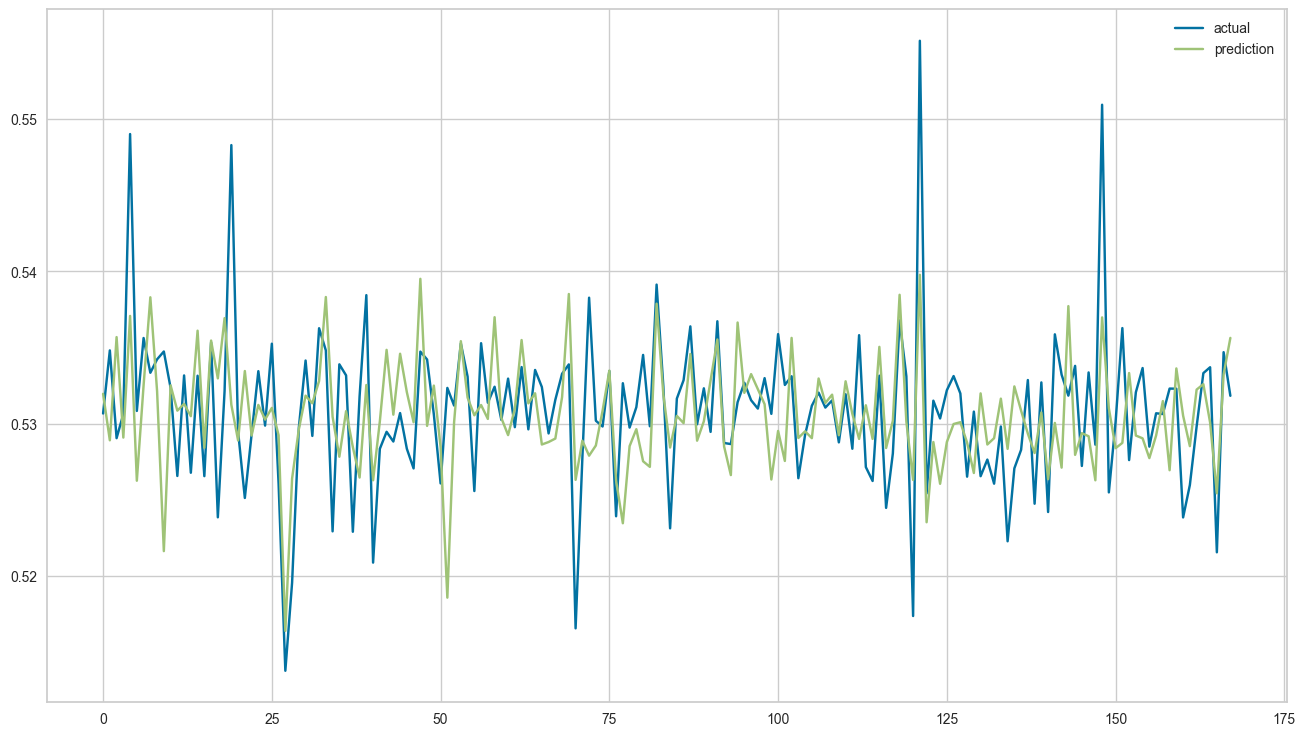

In [224]:
def graph(pred, true) :
    plt.figure(figsize=(16, 9))
    plt.plot(true, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

true_y = total_predictions[CHECK]['Y_Quality'].to_numpy()
pred_y = total_predictions[CHECK]['prediction_label'].to_numpy()
graph(pred_y, true_y)